In [6]:
!wget https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/ner_dataset.csv

--2021-12-11 19:23:36--  https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/ner_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15208151 (15M) [text/plain]
Saving to: ‘ner_dataset.csv’

ner_dataset.csv     100%[===================>]  14.50M  --.-KB/s    in 0.1s    

2021-12-11 19:23:37 (110 MB/s) - ‘ner_dataset.csv’ saved [15208151/15208151]



In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Loading and exploring the dataset

In [10]:
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [11]:
df = df.fillna(method='ffill')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [22]:
print('words: '+ str(df['Word'].nunique()) +' , POS: '+str(df['POS'].nunique())+' , Tag: '+str(df['Tag'].nunique())+' , Sentences: '+str(df['Sentence #'].nunique()))

words: 35178 , POS: 42 , Tag: 17 , Sentences: 47959


In [23]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [24]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)

In [25]:
num_words, num_tags

(35179, 17)

In [46]:
def get_sent(dff):
  s = []
  for i in dff['Sentence #'].unique():
    s.append(list(df[df['Sentence #'] == i].iloc[:,1:].itertuples(index=False, name=None)))
  return s

In [48]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
        self.grouped = self.df.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [49]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [50]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [57]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

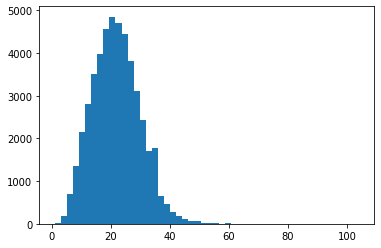

In [58]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show();

In [103]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]       #w[1],w[2] are POS and tag, X is a list of lists
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value = num_words)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [106]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [107]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [113]:
model = Sequential()
model.add(Embedding(input_dim = num_words+1, output_dim = max_len, input_length = max_len))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 50)            1759000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 50, 17)           3417      
 tributed)                                                       
                                                                 
Total params: 1,883,217
Trainable params: 1,883,217
Non-trainable params: 0
____________________________________________

In [114]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [115]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [116]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [ early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
1080/1080 [==============================] - 258s 235ms/step - loss: 0.1903 - accuracy: 0.9566 - val_loss: 0.0667 - val_accuracy: 0.9808
Epoch 2/3
1080/1080 [==============================] - 237s 219ms/step - loss: 0.0526 - accuracy: 0.9845 - val_loss: 0.0502 - val_accuracy: 0.9848
Epoch 3/3
1080/1080 [==============================] - 237s 219ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.0480 - val_accuracy: 0.9853


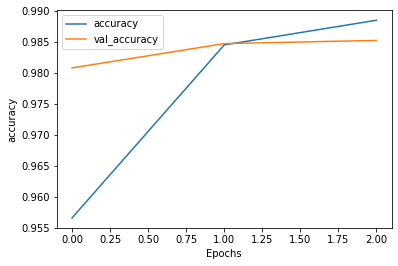

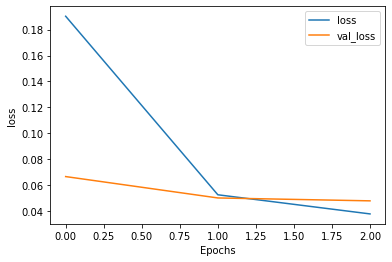

In [117]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [118]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 5s 31ms/step - loss: 0.0494 - accuracy: 0.9853


[0.04940798133611679, 0.9852710366249084]

In [123]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
been           O	O
seeking        O	O
diplomatic     O	O
pressure       O	O
to             O	O
get            O	O
the            O	O
North          B-geo	B-geo
to             O	O
return         O	O
to             O	O
six            O	O
party          O	O
talks          O	O
.              O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPAD         O	O
ENDPA

In [105]:
X[0]

array([32020, 33188, 19307,  4882, 16332, 31799, 25384, 14192, 17389,
        8649, 27212,  8400,  8986,  7001, 25653,  8649, 33307, 33188,
        4291, 28730, 15748,  4571,  3839,   166, 35179, 35179, 35179,
       35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179,
       35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179, 35179,
       35179, 35179, 35179, 35179, 35179], dtype=int32)